## Expectations
Build a search ranking model for bookable listings.

## Metrics

### Offline: Normalized Discounted Cumulative Gain (NDCG)
NDCG is often used as a quality of search ranking results. It allows to calculate whether releavant search listings 
are appearing earlier  in the results. To compute NDCG for the overall search results with N queries, we take the mean of the respective NDCGs of all the N queries.

### Online: Revenue
In an online setting, the success could be measured by an increase in booking revenue.


In [4033]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

import datetime
from math import log, floor, radians, cos, sin, asin, sqrt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV,  ShuffleSplit

from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# to see all the columns printed
pd.options.display.max_columns = None

# Data Import And Basic Stats

In [4034]:
df = pd.read_csv('data.csv')

In [ ]:
df.head()

In [ ]:
df.describe()

A few potential issues could be already seen at this point
1. missing values
2. negative values in multiple columns
3. very high max price, potential outliers

In [ ]:
print("Number of rows", df.shape[0])
print("Number of cols", df.shape[1])

## Understanding Data

### Label Distribution

In [ ]:
df.label.unique()

In [ ]:
df.label.value_counts()

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x="label", data=df)
plt.title('What is the action distribution in label (%)?')
ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('Frequency [%]')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/df.label.count()), (x.mean(), y), 
            ha='center', va='bottom')
plt.show()


Out of all search results we have (13%) of listings with bookings.

Initially I will work on the model to predict the probability of booking. Since click, host_contact can also indicate an interest from the user, later on I could look at the combined probability to book, contact_host, click with weights to improve the ranking score.

In [4041]:
df['booked'] = np.where(df['label'] == 'book', 1, 0)
df['clicked'] = np.where(df['label'] == 'click', 1, 0)
df['contacted'] = np.where(df['label'] == 'host_contact', 1, 0)
df['impression'] = np.where(df['label'] == 'impression', 1, 0)

conditions = [
    (df['label'] == 'book'),
    (df['label'] == 'host_contact'),
    (df['label'] == 'click'),
    (df['label'] == 'impression')]

choices = [1.0, 0.5, 0.3, 0]

df['action'] = np.select(conditions, choices)
#df = df.drop(columns = ['label'])

In [ ]:
df.action.value_counts()

### What do we know about search id?

In [ ]:
#How many listings are in search?
df1 = df.groupby("id_search")["id_listing"].nunique()
df1.describe()

The number of listings ranges from 1 to 18 with average of 2. I suspect that the lower  and upper bounds could be limited by the snapshot of the dataset and not necessary what 
user could see in particular search query.

In [ ]:
# How many searches with bookings?
df.id_search.nunique()

In [ ]:
df.id_user.nunique()

In [ ]:
df.id_listing.nunique()

In [4047]:
df1 = df.groupby(["id_search"]).agg({"booked": np.sum})
df1_booked = df1[df1.booked != 0]

There are 2218 searches with bookings
How many average listings in searches with bookings?

In [ ]:
search_id_with_booking = df1_booked.index.tolist()
df_with_bookings = df[df['id_search'].isin(search_id_with_booking)] 
df_with_bookings.label.value_counts()

In [ ]:
df_with_bookings.loc[(df_with_bookings.id_search == '3b3a5ee9-6a4d-4cae-a7a2-caf9fb44e949')]

In [ ]:
df_with_bookings = df[df['id_search'].isin(search_id_with_booking)] 
df1 = df_with_bookings.groupby("id_search")["id_listing"].nunique()
df1.describe()

In searches with bookings, there are on average 6 listings. For evaluation of NDCG @k, I will use the average k == 6

In [ ]:
# Listings are unique within a specific search id, since only the last action on that listing is being recorded.
# Lets look at the situation when the same user, acts on the same listing same day
df1 = df.groupby(['id_user', 'id_listing', 'ds_search', "label"]).size().sort_values(ascending=False).reset_index(name='count')
df1.head()

In [ ]:
#The same user booked the same listing on the same day, we need to take a closer look.
df.loc[(df.id_user == '99cd10f6ab7f9eacba5222c7179c882d') & (df.id_listing == 'f596a76ad5fb342fde248fb6ec07dcf2') & (df.ds_search == '11/22/18')]

The same listing was booked by the same person 4 times on the same day. For user those were different searches for the same timeframe, but different number of of guests in the query.

At this point I will assume that if listing was booked by the same user on the same day, the listing is marked as 'book' in all searchers
on that day.  Given that we are dealing with imbalanced dataset I am going to keep all those records nonetheless.

The above query contains the same listing, but listing_num_beds == 4 in 3 out of 4 rows and NaN in 1. At this point
I will assume that NaN was a result of a logging problem. Therefore I think using median or KNN as imputer strategy might be reasonable.

# Data Preprocessing

## Processing Dates

We are working with 7 days window of data. Calculating historic observation in this timeframe, might put some
users observations outside of the data window, even for a single. day aggregations as the data might have been incomplete for upper and 
lower bound days.
Therefore, the meaningful calculations that are unaffected by the time window are:
    1. Days of the week
    2. Time between checkin-checkout
    3. Time between search query and checkin

In [4053]:
df['search_date'] = pd.to_datetime(df['ds_search'])
df['search_time_day_name'] = df.search_date.dt.day_name()
df['checkin_date'] = pd.to_datetime(df['query_checkin'])
df['checkin_date_day_name'] = df.checkin_date.dt.day_name()
df['checkout_date'] = pd.to_datetime(df['query_checkout'])
df['checkout_date_day_name'] = df.checkout_date.dt.day_name()
df['checkin_checkout_days_between'] = (df.checkout_date - df.checkin_date).dt.days
df['search_checkin_days_between'] = (df.checkin_date - df.search_date).dt.days

I will drop the date column. Given the short timeframe, day name might carry out more. information than just dates

In [4054]:
df = df.drop(columns = ['query_checkin', 'query_checkout', 'search_date', 'checkin_date', 'checkout_date'])

## Processing Geo Coordinates And Distance

The search queries contain geo coordinates for search and listings.

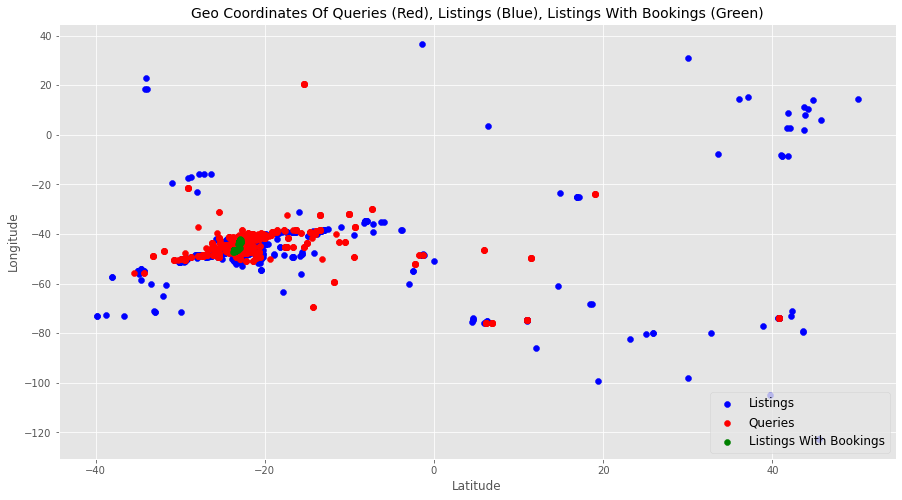

In [4055]:
df1_booked = df[df.booked != 0]

plt.figure(figsize = (15,8))
plt.xlabel('Latitude')  
plt.ylabel('Longitude')  
  
# displaying the title 
plt.title("Geo Coordinates Of Queries (Red), Listings (Blue), Listings With Bookings (Green)", fontsize=14) 

l = plt.scatter(df['listing_lat'], df['listing_lng'], color='b')
q = plt.scatter(df['query_center_lat'], df['query_center_lng'], color='r')
b = plt.scatter(df1_booked['listing_lat'], df1_booked['listing_lng'], color='g')

plt.legend((l,q,b),('Listings', 'Queries','Listings With Bookings'),scatterpoints=1, loc='lower right', ncol=1, fontsize=12)
plt.show()

Some listings are located further away from search centers and those listings did not result in booking. Distance between query center and listing geo coordine might be important in decision top book for a user. To capture that I will calculate distance between query search and listings

In [4056]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6371* c
    return km

In [4057]:
df['distance'] = df.apply(lambda row : haversine(row['query_center_lng'], row['query_center_lat'], row['listing_lng'],  row['listing_lat']), axis=1)

In [4058]:
#df["query_center_lng_rad"] = np.radians(df["query_center_lng"])
#df["query_center_lat_rad"] = np.radians(df["query_center_lat"])
#df["listing_lng_rad"] = np.radians(df["listing_lng"])
#df["listing_lat_rad"] = np.radians(df["listing_lat"])

As an advanced step, **TODO** I would reverse geocode lat, lng into postal code or convert them into a geohash, as neighbourhood might be a significant predictor.
For now I'll just drop them and focus on the significance of distance alone

In [4059]:
df = df.drop(columns = ['query_center_lng', 'query_center_lat', 'listing_lng', 'listing_lat'])

## Adding User Action Per Day

In the dataset we are missing user-specific features. At the moment I will assume that rows in the dataset are being logged chronologically.

cum_action_per_day will calculate user cumulative steps each day for each listing. On the same day, first chronoligical listing action will count as 0, than 1, etc.

In [4060]:
df['cum_user_action_per_day'] = df.groupby(['id_user', 'ds_search']).cumcount(ascending=False)

In [4061]:
correlations = df.corr()['booked'].dropna().sort_values()
print(correlations['cum_user_action_per_day'])

-0.030893642441661352


## Handling Missing Values

In [ ]:
import missingno as msno

msno.matrix(df.iloc[:, 0:50])

Data appears to be missing completely at random (MCAR).

In [ ]:
msno.bar(df.iloc[:, 0:50])

Removing data leakage columns

In [4064]:
df = df.drop(columns = ['ds_search', 'ds_book', 'ds_contact'])

In [4065]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
                
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        return mis_val_table_ren_columns
#missing_data = missing_values_table(df)
#print(missing_data)

In [4066]:
def complex_imputation(data, features):
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=2)
    columns = features
    for col in columns:
        df[col] = imputer.fit_transform(df[[col]]).ravel()

In [4067]:
def simple_imputation(data, features):
    for feature_name in features:
        missing_ids = data.loc[data[feature_name].isna(), :].index.values
        imp_val = data[feature_name].median()
        imputed_feature = [imp_val] * len(data.loc[missing_ids, feature_name])
        data.loc[missing_ids, feature_name] = imputed_feature


In [4068]:
#complex_imputation(df, missing_data.index)

Processing KNN takes some time, for the sake of efficient time utilization, I will use simple median imputation

In [4069]:
simple_imputation(df, missing_data.index)

In [4070]:
missing_values_table(df)

Your selected dataframe has 51 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Handling Outliers

### Price

As the total price can be correlated to the number of days between checkin and check out, 
lets first normalized that price by the number of days.
From the dataframe description above it appears that listing_total_price might have potential outliers.
Lets take a look.

In [ ]:
df['listing_total_price'].describe()

In [4072]:
df['listing_price_per_day'] = df['listing_total_price']/ df['checkin_checkout_days_between']

In [ ]:
upper_bound = df['listing_price_per_day'].quantile(.99)
print(upper_bound)

lower_bound = df['listing_price_per_day'].quantile(.01)
print(lower_bound)

In [ ]:
df['listing_price_per_day'].describe()

In [ ]:
df[df['listing_price_per_day'] > upper_bound].booked.value_counts()

Average listing price per day is 114, but could go up to above $500K. This are the outliers that are likely to skew the picture.

In [ ]:
df[df['listing_price_per_day'] < lower_bound].booked.head()

The upper outliers did not result into any bookings. The lower outliers contain. booking with $0 price
As we are focusing on revenue generation, I will remove those from the dataset.

In [4077]:
df = df[(df['listing_price_per_day'] < upper_bound) & (df['listing_price_per_day'] > lower_bound)] 

## Addressing Negative Ratings

There are negative value in the scale of ratings. I am going to adjust the scale to start with 0.

In [4078]:
df['listing_location_rating'] = np.where(df['listing_location_rating'] < 0, 0, df['listing_location_rating'])
df['listing_cleanliness_rating'] = np.where(df['listing_cleanliness_rating'] < 0, 0, df['listing_cleanliness_rating'])
df['listing_checkin_rating'] = np.where(df['listing_checkin_rating'] < 0, 0, df['listing_checkin_rating'])
df['listing_value_rating'] = np.where(df['listing_value_rating'] < 0, 0, df['listing_value_rating'])
df['listing_communication_rating'] = np.where(df['listing_communication_rating'] < 0, 0, df['listing_communication_rating'])
df['listing_accuracy_rating'] = np.where(df['listing_accuracy_rating'] < 0, 0, df['listing_accuracy_rating'])

Min max query price contains negative values that I assume are searches without min-max being set. 
Since there could be no negative price, I will adjust query_price_min to start with 0.
And for max price if negative, I'll assume listing_total_price

In [4079]:
#TO evaluate: if user specifies min price as 0 that may carry additional information
df['query_price_min'] = np.where(df['query_price_min'] < 0, 0, df['query_price_min'])
df['query_price_max'] = np.where(df['query_price_max'] < 0, df['listing_total_price'], df['query_price_max'])

## Handling Data Types

In [ ]:
df['listing_has_pro_pictures'] = df['listing_has_pro_pictures'].astype('int')
df['listing_monthly_discount'] = df['listing_monthly_discount'].astype('int')
df['listing_weekly_discount'] = df['listing_weekly_discount'].astype('int')
df['listing_instant_bookable'] = df['listing_instant_bookable'].astype('int')

df['action'] = df['action'].astype('float')

categorical_cols  = ['query_market', 'search_time_day_name', 'checkin_date_day_name', 'checkout_date_day_name', 'listing_property_type', 'listing_room_type']
df = pd.get_dummies(df, columns = categorical_cols)

df.head()


In [ ]:
df.label.value_counts()

## Distributions & Scaling

In [4082]:
def log_feature(data, feature_name):
    log_feature = data[feature_name].apply(lambda x: log((x+1)))
    return log_feature

In [4083]:
def standardize_features(data, col_names):
    features = data[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)

In [4084]:
def normalize_features(data, col_names):
    features = data[col_names]
    scaler = MinMaxScaler().fit(features.values)
    features = scaler.transform(features.values)

### listing_total_price

In [4085]:
df['listing_price_per_day'] = df['listing_total_price']/ df['checkin_checkout_days_between']

In [ ]:
df['listing_price_per_day'].hist(bins=50)

In [4087]:
df['log_price_per_day'] = log_feature(df, 'listing_price_per_day')

In [ ]:
df['log_price_per_day'].hist(bins=50)

In [4089]:
df  = df.drop(columns=['listing_total_price', 'listing_price_per_day'])

In [ ]:
df['query_price_max'].hist(bins=50)

In [4091]:
df['log_query_price_max'] = log_feature(df, 'query_price_max')

In [ ]:
df['log_query_price_max'].hist(bins=50)

In [4093]:
df  = df.drop(columns=['query_price_max'])

In [ ]:
df['listing_cleaning_fee_per_day'] = df['listing_cleaning_fee']/ df['checkin_checkout_days_between']
df['listing_cleaning_fee_per_day'].hist(bins=50)

In [4095]:
df['log_cleaning_fee_per_day'] = log_feature(df, 'listing_cleaning_fee_per_day')

In [4096]:
df  = df.drop(columns=['listing_cleaning_fee_per_day'])

### Distributions 

In [4098]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt


# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.norm, st.lognorm, st.powerlaw, st.powerlognorm, st.uniform, st.expon
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception as e:
            print("Error on: {} {}".format(distribution, str(e)))
            pass

        #print("Distribution: {} | SSE: {}".format(distribution, sse))

    return best_distribution.name, best_sse

In [4099]:
#for col in df.select_dtypes('number'):
#    nm, pm = best_fit_distribution(df[col])
#    print(col, nm, pm)

In [ ]:
# Create the scaler data with a range of 0-1
cols= [ "query_price_min", 'query_num_guests',  'query_num_children', 'query_radius', 'query_num_infants', 'listing_review_rating',
           'listing_review_count', 'listing_num_beds', 'listing_num_bedrooms', 'listing_person_capacity', 'listing_location_rating','listing_cleanliness_rating',
           'listing_checkin_rating',  'listing_value_rating', 'listing_communication_rating', 'listing_accuracy_rating',
           'listing_occupancy_rate', 'listing_cleaning_fee', 'listing_num_books_90day', 'listing_monthly_price_factor',  'listing_weekly_price_factor',
           'distance', 'listing_maximum_nights',  'listing_minimum_nights', 'listing_num_recent_reservations', 'checkin_checkout_days_between', 
           'search_checkin_days_between']

standardize_features(df,cols)
df.head()

## Correlations

In [ ]:
# Find all correlations and sort 
correlations = df.corr()['booked'].sort_values()
print(correlations.head(15), '\n')
print(correlations.tail(15))

listing_occupancy_rate  has the strongest positive correlation to book, others are ratings, listing_num_books_90day (which might have causality relation with ratings), listing_review_count, 
discounts and listing being instantly bookable.

The negative correlations are listing_is_new, listing_person_capacity, listing_total_price, listing_num_beds

In [4133]:
correlations['listing_is_new']

-0.02640913941836243

# Split Into Training and Testing Sets

We need to split data by the id_search to ensure that the records that belong to the same id_search are not being separated into different datasets.

In addition we are dealing with a heavily imbalanced dataset. To counter that with it I will downsample the majority class and upsample the minority

In [4103]:
df_summary = df.groupby(["id_search"]).agg({"booked": np.sum, "clicked": np.sum, "contacted": np.sum, "impression": np.sum})

In [4104]:
df_booked = df_summary[df_summary.booked != 0]

In [4105]:
booked_ids = df_booked.index.tolist()

In [ ]:
df_with_bookings = df[df['id_search'].isin(booked_ids)]
df_with_bookings.label.value_counts()

In [4107]:
df_with_bookings_upsampled = resample(df_with_bookings, replace=True, n_samples=20000, random_state=42)

In [ ]:
df_with_bookings_upsampled.label.value_counts()

In [4109]:
df_impression_only = df_summary[(df_summary.booked == 0) & (df_summary.clicked == 0) & (df_summary.contacted == 0)]
impression_only_ids = df_impression_only.index.values
sample = np.random.choice(impression_only_ids.tolist(), floor(0.2*len(impression_only_ids)), False)
sampled_impression_only_ids = df_summary.loc[sample].index.values

In [ ]:
df_impression_only = df[df['id_search'].isin(sampled_impression_only_ids)] 
df_impression_only.label.value_counts()

In [4111]:
new_df = pd.concat([df_with_bookings_upsampled, df_impression_only]).reset_index()

In [ ]:
new_df.label.value_counts()

In [4113]:
train_id = pd.Series(new_df['id_search'].unique()).sample(10000, replace=True)
train = new_df.loc[new_df['id_search'].isin(train_id)]
test = new_df.loc[~new_df['id_search'].isin(train_id)]

In [4114]:
print(train.shape)
print(test.shape)

(24073, 118)
(14005, 118)


In [ ]:
train.booked.value_counts()

In [ ]:
test.booked.value_counts()

In [4117]:
clicked_list = test['clicked']
booked_list = test['booked']
contacted_list = test['contacted']
srchid_list = test['id_search']

In [4118]:
y_train = train['booked']
X_train = train.drop(columns=['id_listing', 'id_search', 'label', 'id_user', 'booked', 'clicked', 'contacted', 'impression', 'action', 'id_search'])

y_test = test['booked']
X_test = test.drop(columns=['id_listing', 'id_search','label', 'id_user',  'booked', 'clicked', 'contacted', 'impression',  'action', 'id_search'])


## Establish a Benchmark

In [4119]:
def print_model_results(name, test, pred):
    f1score = f1_score(test, pred)
    aucscore = roc_auc_score(test, pred)

    confusion_Matrix = pd.DataFrame(
        confusion_matrix(y_test, pred),
        columns=['Predicted As No', 'Predicted As Yes'],
        index=['True No', 'True Yes'])

    print(classification_report(y_test, pred))
    print(confusion_Matrix)
    print('%s  f1_score =  %0.4f.' % (name, f1score))
    print('%s  roc_auc_score =  %0.4f.' % (name, aucscore))   

### Decision Tree Classifier

Since the dataset contains categorical variables, I will use to establish a baseline model before any optimization.

Model's optimirzation should focus on F1 score since it is important to capture all potential booking and be precise about what we are ranking first.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, cohen_kappa_score, classification_report, recall_score, precision_score

model1 = DecisionTreeClassifier(class_weight='balanced')
model1.fit(X_train, y_train)
y_pred1 =  model1.predict(X_test)
print_model_results("DecisionTreeClassifier", y_test, y_pred1)

### Auto ML With TPOT

In [4121]:
#from ipywidgets import IntProgress
#from tpot import TPOTClassifier
#tpot = TPOTClassifier(generations=2, population_size=20, cv=3, random_state=42, verbosity=3, scoring='roc_auc_ovr_weighted')
#tpot.fit(X_train, y_train)
#print(tpot.score(X_test, y_test))

### Best Result

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
model7 = ExtraTreesClassifier(n_estimators=100, max_features=0.55, 
                              min_samples_leaf=6, min_samples_split=11, criterion='entropy', bootstrap=False, 
                              class_weight='balanced', ccp_alpha=0.001, random_state=0)

model7.fit(X_train, y_train)
y_pred7 =  model7.predict(X_test)

print_model_results("ExtraTreesClassifier", y_test, y_pred7)

importances = model2.feature_importances_
std = np.std([model2.feature_importances_ for tree in model2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%s. feature %d (%f)" % ( X_train.columns[f],  indices[f], importances[indices[f]]))


## AutoML H2O

In [4123]:
import h2o
from h2o.automl import H2OAutoML
h2o.init(
    nthreads=-1,     
    max_mem_size=6
)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 2 hours 29 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.5
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_i803030_8e2syj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.722 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [4131]:
x = X_train.columns.tolist()
X_y_train_h = h2o.H2OFrame(pd.concat([X_train, y_train], axis='columns'))
X_y_train_h['booked'] = X_y_train_h['booked'].asfactor()

X_y_test_h = h2o.H2OFrame(pd.concat([X_test, y_test], axis='columns'))
X_y_train_h.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:24073
Cols:110




,index,query_num_guests,query_num_children,query_num_infants,query_radius,query_price_min,listing_is_new,listing_instant_bookable,listing_review_rating,listing_review_count,listing_num_beds,listing_num_bedrooms,listing_num_bathrooms,listing_person_capacity,listing_has_pro_pictures,listing_num_recent_reservations,listing_location_rating,listing_cleanliness_rating,listing_checkin_rating,listing_value_rating,listing_communication_rating,listing_accuracy_rating,listing_num_books_90day,listing_occupancy_rate,listing_monthly_discount,listing_weekly_discount,listing_cleaning_fee,listing_monthly_price_factor,listing_weekly_price_factor,listing_minimum_nights,listing_maximum_nights,checkin_checkout_days_between,search_checkin_days_between,distance,cum_user_action_per_day,query_market_City A,query_market_City B,search_time_day_name_Friday,search_time_day_name_Monday,search_time_day_name_Sunday,search_time_day_name_Thursday,search_time_day_name_Tuesday,search_time_day_name_Wednesday,checkin_date_day_name_Friday,checkin_date_day_name_Monday,checkin_date_day_name_Saturday,checkin_date_day_name_Sunday,checkin_date_day_name_Thursday,checkin_date_day_name_Tuesday,checkin_date_day_name_Wednesday,checkout_date_day_name_Friday,checkout_date_day_name_Monday,checkout_date_day_name_Saturday,checkout_date_day_name_Sunday,checkout_date_day_name_Thursday,checkout_date_day_name_Tuesday,checkout_date_day_name_Wednesday,listing_property_type_0.0,listing_property_type_1.0,listing_property_type_2.0,listing_property_type_3.0,listing_property_type_4.0,listing_property_type_5.0,listing_property_type_6.0,listing_property_type_8.0,listing_property_type_9.0,listing_property_type_10.0,listing_property_type_11.0,listing_property_type_15.0,listing_property_type_16.0,listing_property_type_17.0,listing_property_type_19.0,listing_property_type_22.0,listing_property_type_23.0,listing_property_type_24.0,listing_property_type_29.0,listing_property_type_32.0,listing_property_type_33.0,listing_property_type_34.0,listing_property_type_35.0,listing_property_type_36.0,listing_property_type_37.0,listing_property_type_38.0,listing_property_type_40.0,listing_property_type_41.0,listing_property_type_42.0,listing_property_type_43.0,listing_property_type_44.0,listing_property_type_45.0,listing_property_type_47.0,listing_property_type_50.0,listing_property_type_52.0,listing_property_type_53.0,listing_property_type_54.0,listing_property_type_56.0,listing_property_type_57.0,listing_property_type_58.0,listing_property_type_60.0,listing_property_type_63.0,listing_property_type_64.0,listing_property_type_65.0,listing_property_type_67.0,listing_property_type_70.0,listing_room_type_Entire Home,listing_room_type_Private Room,listing_room_type_Shared Room,log_price_per_day,log_query_price_max,log_cleaning_fee_per_day,booked
type,int,int,int,int,real,int,int,int,real,int,int,int,real,int,int,int,real,real,real,real,real,real,int,real,int,int,real,real,real,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,real,real,real,enum
mins,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2206628190197833,0.2991225699760877,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3564317492220133,1.3564317492220133,0.0,
mean,89548.65492460437,2.463423752752049,0.15232833464877665,0.04486354006563366,11.898760613437966,4.3647239646076486,0.15639928550658413,0.6383500186931417,3.7867642399368564,23.715573464046848,2.5845137706143726,1.40842437

In [4125]:
aml = H2OAutoML(
    max_runtime_secs=(3600 * 1),  # 1 hours
    max_models=None,  # no limit
    seed=17,
    keep_cross_validation_predictions = True,
    keep_cross_validation_fold_assignment = True,
    sort_metric = "logloss"
)
aml.train(x=x, y="booked", training_frame=X_y_train_h)
lb = aml.leaderboard
lb.head(rows=lb.nrows) 

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210325_233034,0.121844,0.897859,0.787611,0.154314,0.163606,0.0267669
StackedEnsemble_BestOfFamily_AutoML_20210325_233034,0.122612,0.897968,0.787019,0.154733,0.164293,0.0269923
GBM_4_AutoML_20210325_233034,0.140589,0.887192,0.778689,0.154991,0.168322,0.0283324
GBM_grid__1_AutoML_20210325_233034_model_4,0.140678,0.88841,0.782913,0.154459,0.164916,0.0271972
GBM_3_AutoML_20210325_233034,0.142548,0.883521,0.775868,0.156468,0.17241,0.0297253
GBM_grid__1_AutoML_20210325_233034_model_10,0.143039,0.883234,0.773234,0.156491,0.173178,0.0299908
GBM_2_AutoML_20210325_233034,0.144275,0.88075,0.774766,0.155658,0.173871,0.0302311
GBM_grid__1_AutoML_20210325_233034_model_2,0.144414,0.879653,0.773908,0.154474,0.168712,0.0284639
GBM_grid__1_AutoML_20210325_233034_model_9,0.145872,0.88462,0.779958,0.154147,0.168192,0.0282885
GBM_5_AutoML_20210325_233034,0.146702,0.879871,0.773762,0.154335,0.173673,0.0301622


In [4126]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20210325_233034

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0005368551689642924
RMSE: 0.02317013528152765
LogLoss: 0.022166150584943124
Null degrees of freedom: 10021
Residual degrees of freedom: 10007
Null deviance: 5812.106178792043
Residual deviance: 444.2983223246001
AIC: 474.2983223246001
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8189088918672589: 


,,0,1,Error,Rate
0,0,9174.0,0.0,0.0,(0.0/9174.0)
1,1,0.0,848.0,0.0,(0.0/848.0)
2,Total,9174.0,848.0,0.0,(0.0/10022.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.818909,1.000000,126.0
1,max f2,0.818909,1.000000,126.0
2,max f0point5,0.818909,1.000000,126.0
3,max accuracy,0.818909,1.000000,126.0
4,max precision,0.999263,1.000000,0.0
5,max recall,0.818909,1.000000,126.0
6,max specificity,0.999263,1.000000,0.0
7,max absolute_mcc,0.818909,1.000000,126.0
8,max min_per_class_accuracy,0.818909,1.000000,126.0
9,max mean_per_class_accuracy,0.818909,1.000000,126.0



Gains/Lift Table: Avg response rate:  8.46 %, avg score: 10.51 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010078,0.998709,11.818396,11.818396,1.000000,0.998954,1.000000,0.998954,0.119104,0.119104,1081.839623,1081.839623,0.119104
1,2,0.020056,0.998133,11.818396,11.818396,1.000000,0.998444,1.000000,0.998700,0.117925,0.237028,1081.839623,1081.839623,0.237028
2,3,0.030034,0.997715,11.818396,11.818396,1.000000,0.997949,1.000000,0.998451,0.117925,0.354953,1081.839623,1081.839623,0.354953
3,4,0.040112,0.996854,11.818396,11.818396,1.000000,0.997332,1.000000,0.998170,0.119104,0.474057,1081.839623,1081.839623,0.474057
4,5,0.050090,0.995746,11.818396,11.818396,1.000000,0.996326,1.000000,0.997802,0.117925,0.591981,1081.839623,1081.839623,0.591981
5,6,0.100080,0.037612,8.162006,9.992024,0.690619,0.693187,0.845464,0.845646,0.408019,1.000000,716.200618,899.202393,0.983104
6,7,0.150070,0.030802,0.000000,6.663564,0.000000,0.033247,0.563830,0.575027,0.000000,1.000000,-100.000000,566.356383,0.928494
7,8,0.200060,0.028154,0.000000,4.998504,0.000000,0.029344,0.422943,0.438674,0.000000,1.000000,-100.000000,399.850374,0.873883
8,9,0.300040,0.025511,0.000000,3.332890,0.000000,0.026705,0.282009,0.301397,0.000000,1.000000,-100.000000,233.288992,0.764661
9,10,0.400020,0.023913,0.000000,2.499875,0.000000,0.024683,0.211524,0.232236,0.000000,1.000000,-100.000000,149.987528,0.655439




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.02676693293075311
RMSE: 0.16360602962835175
LogLoss: 0.12184356012773448
Null degrees of freedom: 24072
Residual degrees of freedom: 24057
Null deviance: 14340.964349605048
Residual deviance: 5866.280045909904
AIC: 5898.280045909904
AUC: 0.8978592468197784
AUCPR: 0.7876108232432837
Gini: 0.7957184936395567

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8560870368835501: 


,,0,1,Error,Rate
0,0,21948.0,7.0,0.0003,(7.0/21955.0)
1,1,653.0,1465.0,0.3083,(653.0/2118.0)
2,Total,22601.0,1472.0,0.0274,(660.0/24073.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.856087,0.816156,81.0
1,max f2,0.689671,0.736757,86.0
2,max f0point5,0.856087,0.914939,81.0
3,max accuracy,0.856087,0.972583,81.0
4,max precision,0.999059,1.000000,0.0
5,max recall,0.017145,1.000000,397.0
6,max specificity,0.999059,1.000000,0.0
7,max absolute_mcc,0.856087,0.817379,81.0
8,max min_per_class_accuracy,0.032751,0.815392,297.0
9,max mean_per_class_accuracy,0.428413,0.845847,102.0



Gains/Lift Table: Avg response rate:  8.80 %, avg score:  8.80 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010011,0.997987,11.365911,11.365911,1.000000,0.998640,1.000000,0.998640,0.113787,0.113787,1036.591124,1036.591124,0.113787
1,2,0.020022,0.996700,11.365911,11.365911,1.000000,0.997436,1.000000,0.998038,0.113787,0.227573,1036.591124,1036.591124,0.227573
2,3,0.030034,0.994572,11.365911,11.365911,1.000000,0.995739,1.000000,0.997272,0.113787,0.341360,1036.591124,1036.591124,0.341360
3,4,0.040003,0.990135,11.365911,11.365911,1.000000,0.992394,1.000000,0.996056,0.113314,0.454674,1036.591124,1036.591124,0.454674
4,5,0.050015,0.981297,11.365911,11.365911,1.000000,0.986214,1.000000,0.994086,0.113787,0.568461,1036.591124,1036.591124,0.568461
5,6,0.100029,0.054080,3.086921,7.226416,0.271595,0.292914,0.635797,0.643500,0.154391,0.722852,208.692108,622.641616,0.682906
6,7,0.150002,0.040489,0.746390,5.067604,0.065669,0.045765,0.445860,0.444365,0.037299,0.760151,-25.361015,406.760374,0.669010
7,8,0.200017,0.035010,0.698569,3.975118,0.061462,0.037428,0.349740,0.342610,0.034939,0.795090,-30.143070,297.511828,0.652480
8,9,0.300004,0.030029,0.462758,2.804494,0.040715,0.032207,0.246746,0.239157,0.046270,0.841360,-53.724167,180.449374,0.593580
9,10,0.399992,0.027249,0.406094,2.204956,0.035729,0.028550,0.193997,0.186510,0.040604,0.881964,-59.390595,120.495609,0.528468


In [4127]:
aml.leader.predict(X_test_h)

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,p0,p1
0,0.965465,0.034535
0,0.967733,0.0322666
0,0.977654,0.0223456
0,0.972699,0.0273013
0,0.976422,0.023578
0,0.97845,0.0215496
0,0.976382,0.0236184
0,0.973544,0.0264562
0,0.974935,0.0250654
0,0.969201,0.0307992


## H2O Results

In [4132]:
aml.leader.model_performance(X_y_test_h)


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.07783281807207904
RMSE: 0.2789853366614078
LogLoss: 0.3074674883972936
Null degrees of freedom: 14004
Residual degrees of freedom: 13990
Null deviance: 8210.770859191129
Residual deviance: 8612.164350008194
AIC: 8642.164350008194
AUC: 0.6513625648536076
AUCPR: 0.19818073282532578
Gini: 0.3027251297072151

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.039612118937822995: 


,,0,1,Error,Rate
0,0,10841.0,1960.0,0.1531,(1960.0/12801.0)
1,1,791.0,413.0,0.657,(791.0/1204.0)
2,Total,11632.0,2373.0,0.1964,(2751.0/14005.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.039612,0.230920,234.0
1,max f2,0.027797,0.352319,311.0
2,max f0point5,0.069637,0.245828,145.0
3,max accuracy,0.575280,0.916887,20.0
4,max precision,0.997465,1.000000,0.0
5,max recall,0.017272,1.000000,395.0
6,max specificity,0.997465,1.000000,0.0
7,max absolute_mcc,0.575280,0.173824,20.0
8,max min_per_class_accuracy,0.029013,0.609484,300.0
9,max mean_per_class_accuracy,0.029113,0.610398,299.0



Gains/Lift Table: Avg response rate:  8.60 %, avg score:  3.52 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010211,0.148799,5.612672,5.612672,0.482517,0.454051,0.482517,0.454051,0.057309,0.057309,461.267221,461.267221,0.051528
1,2,0.020136,0.094966,2.677884,4.166092,0.230216,0.116263,0.358156,0.287553,0.026578,0.083887,167.788427,316.609234,0.069748
2,3,0.030132,0.076641,2.409498,3.583336,0.207143,0.084829,0.308057,0.220298,0.024086,0.107973,140.949810,258.333596,0.085163
3,4,0.040057,0.067508,2.928936,3.421194,0.251799,0.072334,0.294118,0.183637,0.029070,0.137043,192.893592,242.119406,0.106108
4,5,0.050196,0.062006,1.802150,3.094161,0.154930,0.064457,0.266003,0.159564,0.018272,0.155316,80.215011,209.416100,0.115006
5,6,0.100036,0.047352,1.383182,2.241725,0.118911,0.053111,0.192719,0.106527,0.068937,0.224252,38.318190,124.172459,0.135900
6,7,0.150018,0.041266,1.628488,2.037410,0.140000,0.044107,0.175155,0.085730,0.081395,0.305648,62.848837,103.740981,0.170268
7,8,0.200071,0.037283,1.410449,1.880558,0.121255,0.039083,0.161670,0.074060,0.070598,0.376246,41.044948,88.055785,0.192745
8,9,0.300036,0.032472,1.163206,1.641554,0.100000,0.034670,0.141123,0.060936,0.116279,0.492525,16.320598,64.155437,0.210594
9,10,0.400000,0.029186,1.096737,1.505399,0.094286,0.030736,0.129418,0.053389,0.109635,0.602159,9.673707,50.539867,0.221174


In [ ]:
h2o.save_model(aml.leader, path = "./search_ranking")

### Shallow Neural Networks

In [4149]:

def get_model(units, optimizer):
    model8 = models.Sequential()
    model8.add(layers.Dense(units, input_shape=(X_train.shape[1],), activation='relu'))
    model8.add(layers.Dense(1, activation='sigmoid'))
    model8.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metrics.AUC(name='auc')])

    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

    history = model8.fit(X_train, y_train, batch_size=300, epochs=80, verbose=0, class_weight={0:class_weights[0], 1:class_weights[1]})
                      #callbacks=[EarlyStopping(monitor='auc',min_delta=0.1)])
    return max(history.history['auc'])
auc_score = get_model(64, 'adam')

In [ ]:
print(auc_score)

In [ ]:
y_pred8 = model8.predict(X_test)
y_pred8 =(y_pred8 >= 0.5)

confusion_Matrix = pd.DataFrame(
        confusion_matrix(y_test, y_pred8),
        columns=['Predicted As No', 'Predicted As Yes'],
        index=['True No', 'True Yes'])

print(classification_report(y_test, y_pred8))
print(confusion_Matrix)

# Ranking

## Create Ranking Table

In the final stage I will create a ranking table that can be used to claculate the NDCG.

In [ ]:
result = pd.DataFrame({'probility':y_pred1,'booked':booked_list,'clicked':clicked_list, 'contacted': contacted_list, 'id_search': srchid_list})
result['position'] = 0
result = result.reset_index(0, drop=True)
result['score'] = result['clicked']*1 + result['contacted']*3 + result['booked']*5

In [ ]:
rank = result.groupby('id_search', group_keys=False).apply(lambda x: x.sort_values('probility', ascending=False))
rank_order = rank.groupby('id_search').head(6).reset_index(drop=True)
rank_order['position'] = rank_order.groupby(['id_search'])['position'].rank(method='first').astype(int).astype(str)

In [ ]:
ndgc_input = rank_order.pivot(index='id_search', columns='position', values='score').reset_index()

## Evaluate Ranking Performance

In [ ]:
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
     
    else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [ ]:
ndgc_input['ndcg'] = ndgc_input.iloc[:,1:].apply(lambda x: ndcg_at_k(x, 6), axis=1)
score = ndgc_input['ndcg'].mean()
score

# New Listings

New listings are negatively correlated to the label.
correlations['listing_is_new'] = -0.027

There could be multiple approaches to overcome the problem of new listings being underanked, for example looking at the textual information of the listings, such as title, description, amenities 
and calculate similarities to the users' historic infomation (reviews, information about properties where user stayed and gave a high rating).


# Conclusions and Next Steps

When the  model is optimized for production, it should be able to quickly rank the listings-candate in the 
specific search area according to the probability of booking. If there are too many candidates, first step could be an efficient candidate generation model with focus on high recall and the ranking step on higher precision.

## Next Steps

1. Utilize all actions not only booked for multiclass classification problem to predict the probability of booking. The resulting probabilities could be weighted according to their importance before the final probability if being calculated.
2. Enrich data set with historic user information about his previous actions.
3. Enrich data with geo information by utilizing the reverse geocoding or geohashes as neighbohoord information may play an important role in users decision to book.
4. Enrich data with historic information of the listings (number of clicked in the last week, month, number of contacts with host)
4. Enrich data with temporal information, such as holidays, seasonalty, events, trends.
5. Consider processing textual information from user reviews and listing reviews and calculating similarities.
